In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
base_dir="/eos/home-b/bpinolin/ML_output/"
plot_config="VBSOS"
cut= "sr"
version = "DNN_v7/top_WW_loose/highZ/train"

In [3]:
output_dir = os.path.join(base_dir, plot_config, cut, "samples/", version)

In [4]:
datasets  = ["2016","2017","2018"]
samples_dirs = [os.path.join(base_dir, plot_config, cut, "samples/", version, p) for p in datasets]

In [5]:
lumi = { 2016: 35.867, 2017: 41.5 , 2018: 59.74}

In [6]:
classes = { "WWewk": 0, "top":1, "WW":1}
signal_name = "WWewk"
sample_names = ["WWewk", "top", "WW"]

samples = {}

for samples_dir in samples_dirs:
    for file in os.listdir(samples_dir):
        if os.path.isdir(os.path.join(samples_dir, file)): continue
        sname = file.split("_part")[0]
        print(sname)
        s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
        s["sample_name"]= sname
        s["class"] = classes[sname]
        if sname == signal_name:
            s["signal"] = 1
        else: 
            s["signal"] = 0
            
            
        if "2016" in samples_dir:
            s["year"] = 2016
            s["weight_"] = s["weight_"] * lumi[2016] #lumi is included 
        if "2017" in samples_dir:
            s["year"] = 2017
            s["weight_"] = s["weight_"] * lumi[2017] #lumi is included 
        if "2018" in samples_dir:
            s["year"] = 2018 
            s["weight_"] = s["weight_"] * lumi[2018] #lumi is included 
            
        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s

WW
WWewk
top
WW
WWewk
top
WW
WWewk
top


In [7]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight_).sum():15}")

Sample name WW        , nsamples:       3876,   XS total: 505.33005547963745
Sample name WWewk     , nsamples:       1698,   XS total: 57.146723339720694
Sample name top       , nsamples:      12837,   XS total: 3365.3380324860254


In [8]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.preprocessing import LabelEncoder 

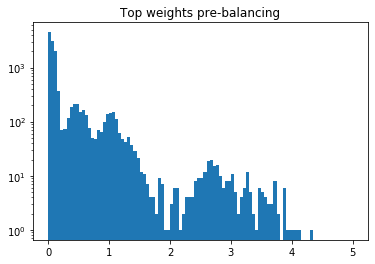

In [9]:
plt.hist(samples["top"]["weight_"], bins=100, range=(0,5))
plt.title("Top weights pre-balancing")
plt.yscale("log")
plt.show()

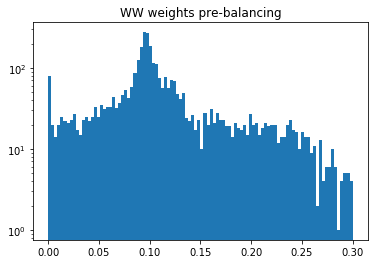

In [10]:
plt.hist(samples["WW"]["weight_"], bins=100, range=(0,0.3))
plt.title("WW weights pre-balancing")
plt.yscale("log")
plt.show()

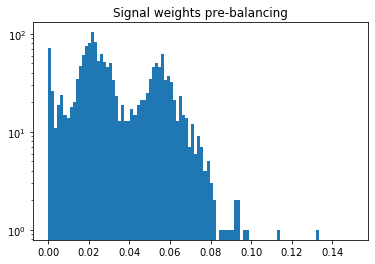

In [11]:
plt.hist(samples["WWewk"]["weight_"], bins=100, range=(0,0.15))
plt.title("Signal weights pre-balancing")
plt.yscale("log")
plt.show()

In [12]:
bkg_list = []
bkg_names = [ name for name in sample_names if name != signal_name ]
for bkg_name in bkg_names:
    bkg_list.append(samples[bkg_name])

background = pd.concat(bkg_list, ignore_index=True)

signal = samples["WWewk"]

In [13]:
background = background.dropna()
signal = signal.dropna()

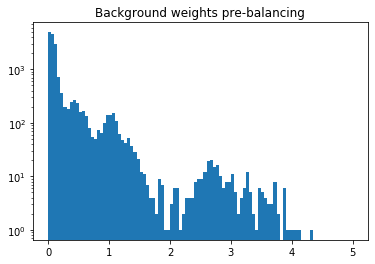

In [14]:
plt.hist(background["weight_"], bins=100, range=(0,5))
plt.title("Background weights pre-balancing")
plt.yscale("log")
plt.show()

In [15]:
signal = signal[(signal['mjj'] >= 500) & (signal["detajj"] >= 3.5)]
background = background[(background['mjj'] >= 500) & (background["detajj"] >= 3.5)]

# Balancing

### Normalization by background events

### Normalization by signal events

In [16]:
print("len_sig = ", len(signal))
print("len_bkg = ", len(background))

ratio_neve_bkgsignal= len(background) / len(signal)
print("\nlenB/lenS = ", round(ratio_neve_bkgsignal,2))

nS = signal.weight_.sum()
nB = background.weight_.sum()
print("\nnS = ", round(signal.weight_.sum(),2))
print("nB = ", round(background.weight_.sum(),2))

rescale_factor_bkg = len(signal) / background.weight_.sum()
print("\nRescale facor for bkg", round(rescale_factor_bkg,2))

signal["weight_norm"] = signal.weight_ / signal.weight_.mean()
background["weight_norm"] = background.weight_ * rescale_factor_bkg

print("\nEffective sig events: ", round(signal.weight_norm.sum(),2))
print("Effective bkg events: ", round(background.weight_norm.sum(),2))

len_sig =  1216
len_bkg =  8044

lenB/lenS =  6.62

nS =  40.73
nB =  1860.78

Rescale facor for bkg 0.65

Effective sig events:  1216.0
Effective bkg events:  1216.0


In [17]:
print(signal.weight_.mean())
print(signal.weight_norm.mean())

0.033496018196222666
1.0


In [18]:
print(background.weight_.mean())
print(background.weight_norm.mean())

0.23132573793385428
0.1511685728493287


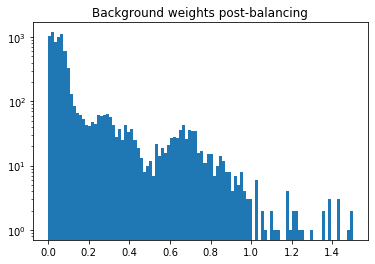

In [19]:
plt.hist(background["weight_norm"], bins=100, range=(0,1.5))
plt.title("Background weights post-balancing")
plt.yscale("log")
plt.show()

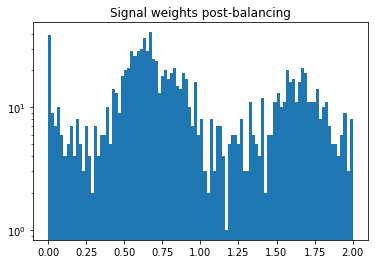

In [20]:
plt.hist(signal["weight_norm"], bins=100, range=(0, 2))
plt.yscale("log")
plt.title("Signal weights post-balancing")
plt.show()

### What I was doing

# Save signal and bkg samples

In [21]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

In [22]:
#v7 top+WW loose
low_sig = 145
low_bkg = 1903

low_sig_2016 = 31
low_bkg_2016 = 493
low_sig_2017 = 42
low_bkg_2017 = 555
low_sig_2018 = 72
low_bkg_2018 = 854

high_sig = 59
high_bkg = 1824

high_sig_2016 = 11
high_bkg_2016 = 470
high_sig_2017 = 17
high_bkg_2017 = 532
high_sig_2018 = 30
high_bkg_2018 = 820